<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Extract_TMS_fMRI_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# --- One-cell notebook: extract Tian-50 + Schaefer-400 parcel time series (Tian first) + build nested dict with metadata ---

import os, re, glob, json
import numpy as np
import pandas as pd
import nibabel as nib

from nilearn.maskers import NiftiLabelsMasker
from nilearn.image import load_img, resample_to_img

# =========================
# CONFIG
# =========================
BASE_DIR   = "/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI"
DERIV_DIR  = os.path.join(BASE_DIR, "derivatives")

# Atlases
SCHAEFER_PATH = os.path.join(BASE_DIR, "atlases", "Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz")
TIAN_PATH     = os.path.join(BASE_DIR, "atlases", "Tian_Subcortex_S3_3T.nii")
TIAN_LABELS   = os.path.join(BASE_DIR, "atlases", "Tian_Subcortex_S3_3T_label.txt")

SUBJECTS_TXT = os.path.join(BASE_DIR, "subjects_all.txt")

EVENTS_PATH_CANDIDATES = [os.path.join(BASE_DIR, "task-stim_events.tsv"), "/mnt/data/task-stim_events.tsv"]
PARTICIPANTS_PATH_CANDIDATES = [os.path.join(BASE_DIR, "participants.tsv"), "/mnt/data/participants.tsv"]

# TR metadata:
TR_REST_S  = 2.0
TR_STIM_S  = 2.4
TR_STIM_ACTUAL_S = 2.1
TR_STIM_GAP_S    = 0.3

STANDARDIZE = "zscore_sample"
DETREND     = True

# =========================
# LOAD SUBJECT LIST
# =========================
with open(SUBJECTS_TXT, "r") as f:
    subjects_all = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith("#")]

# =========================
# HELPERS
# =========================
def first_existing(paths):
    for p in paths:
        if p and os.path.exists(p):
            return p
    return None

def load_json_if_exists(path):
    if path and os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None

# def parse_task_and_coords_from_fname(fname):
#     if "task-rest" in fname:
#         return "task-rest", None
#     if "task-stim" in fname:
#         m = re.search(r"task-stim(\-?\d+)x(\-?\d+)x(\-?\d+)", fname)
#         if not m:
#             raise RuntimeError(f"Cannot parse stimulation coordinates from filename: {fname}")
#         return "task-stim", np.array(list(map(int, m.groups())), dtype=int)
#     return None, None

def parse_task_and_coords_from_fname(fname):
    if "task-rest" in fname:
        return "task-rest", None

    if "task-stim" in fname:
        # capture three tokens separated by x; each token can be:
        #   46
        #   -18
        #   Minus18
        m = re.search(r"task-stim([A-Za-z\-0-9]+)x([A-Za-z\-0-9]+)x([A-Za-z\-0-9]+)", fname)
        if not m:
            raise RuntimeError(f"Cannot parse stimulation coordinates from filename: {fname}")

        def tok2int(tok):
            tok = tok.replace("Minus", "-").replace("minus", "-")
            return int(tok)

        x, y, z = (tok2int(t) for t in m.groups())
        return "task-stim", np.array([x, y, z], dtype=int)

    return None, None


def find_bold_files(func_dir):
    patterns = [
        "*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz",
        "*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii",
    ]
    files = []
    for pat in patterns:
        files.extend(glob.glob(os.path.join(func_dir, pat)))
    return sorted(set(files))

def infer_tr_from_json(json_sidecar, fallback_tr):
    if isinstance(json_sidecar, dict):
        rt = json_sidecar.get("RepetitionTime", None)
        if rt is not None:
            try:
                return float(rt)
            except Exception:
                pass
    return float(fallback_tr)

def stimulated_parcel_from_mni(atlas_img, mni_coord, n_parcels_expected=None):
    """
    atlas_img: labels image in same grid as BOLD (resampled)
    mni_coord: (x,y,z) in mm
    Returns: (stim_mask, label_int) where stim_mask has length = max label in atlas (or n_parcels_expected)
    """
    data = atlas_img.get_fdata()
    inv_aff = np.linalg.inv(atlas_img.affine)
    ijk = nib.affines.apply_affine(inv_aff, mni_coord)
    ijk = np.round(ijk).astype(int)

    if np.any(ijk < 0) or np.any(ijk >= np.array(data.shape)):
        return None, None

    label = int(data[tuple(ijk)])
    if label == 0:
        return None, None

    n_parcels = int(data.max())
    if n_parcels_expected is not None:
        n_parcels = int(n_parcels_expected)

    stim = np.zeros(n_parcels, dtype=int)
    stim[label - 1] = 1
    return stim, label

def load_tian_labels(path_txt):
    """
    Reads label file; returns list length 50 (no background) if possible.
    """
    with open(path_txt, "r") as f:
        labels = [ln.strip() for ln in f if ln.strip()]
    # Some label files include a background line; drop it if present
    if labels and labels[0].lower() in ("background", "bg", "0"):
        labels = labels[1:]
    # Prefix for clarity
    labels = [f"SC_{x}" for x in labels]
    return labels

In [5]:

# =========================
# LOAD AUX FILES
# =========================
events_path = first_existing(EVENTS_PATH_CANDIDATES)
participants_path = first_existing(PARTICIPANTS_PATH_CANDIDATES)

stim_events = pd.read_csv(events_path, sep="\t") if events_path is not None else None
participants = pd.read_csv(participants_path, sep="\t") if participants_path is not None else None

# Sanity checks
for pth, name in [(DERIV_DIR,"DERIV_DIR"), (SCHAEFER_PATH,"Schaefer atlas"), (TIAN_PATH,"Tian atlas"), (TIAN_LABELS,"Tian labels")]:
    if not os.path.exists(pth):
        raise FileNotFoundError(f"{name} not found: {pth}")

# Load atlas images + labels
schaefer_img_native = load_img(SCHAEFER_PATH)
tian_img_native     = load_img(TIAN_PATH)

tian_labels = load_tian_labels(TIAN_LABELS)
if len(tian_labels) != 50:
    print(f"Warning: Tian labels length is {len(tian_labels)} (expected 50). Continuing anyway.")


In [6]:
# --- One-cell notebook: extract Tian-50 + Schaefer-400 (Tian first) and store ALL runs per subject/task ---
# Output structure:
#   dataset[sub_id]['task-rest'][0] -> {'time series', 'metadata'}
#   dataset[sub_id]['task-stim'][0] -> {'time series', 'metadata', 'target', 'stim time'}
# where keys 0,1,2,... index different sessions/runs within each task.

import os, re, glob, json, pickle
import numpy as np
import pandas as pd
import nibabel as nib

from nilearn.maskers import NiftiLabelsMasker
from nilearn.image import load_img, resample_to_img

# =========================
# CONFIG
# =========================
BASE_DIR   = "/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI"
DERIV_DIR  = os.path.join(BASE_DIR, "derivatives")

SCHAEFER_PATH = os.path.join(BASE_DIR, "atlases", "Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz")
TIAN_PATH     = os.path.join(BASE_DIR, "atlases", "Tian_Subcortex_S3_3T.nii")
TIAN_LABELS   = os.path.join(BASE_DIR, "atlases", "Tian_Subcortex_S3_3T_label.txt")

SUBJECTS_TXT = os.path.join(BASE_DIR, "subjects_all.txt")

EVENTS_PATH_CANDIDATES = [os.path.join(BASE_DIR, "task-stim_events.tsv"), "/mnt/data/task-stim_events.tsv"]
PARTICIPANTS_PATH_CANDIDATES = [os.path.join(BASE_DIR, "participants.tsv"), "/mnt/data/participants.tsv"]

# TR metadata
TR_REST_S  = 2.0
TR_STIM_S  = 2.4
TR_STIM_ACTUAL_S = 2.1
TR_STIM_GAP_S    = 0.3

STANDARDIZE = "zscore_sample"
DETREND     = True

OUT_PATH = os.path.join(BASE_DIR, "dataset_tian50_schaefer400_allruns.pkl")

# =========================
# HELPERS
# =========================
def first_existing(paths):
    for p in paths:
        if p and os.path.exists(p):
            return p
    return None

def load_json_if_exists(path):
    if path and os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None

def parse_task_and_coords_from_fname(fname):
    """
    Handles coordinates encoded like:
      task-stim46x26x38
      task-stim40x-18x64
      task-stim40xMinus18x64
    """
    if "task-rest" in fname:
        return "task-rest", None

    if "task-stim" in fname:
        m = re.search(r"task-stim([A-Za-z\-0-9]+)x([A-Za-z\-0-9]+)x([A-Za-z\-0-9]+)", fname)
        if not m:
            raise RuntimeError(f"Cannot parse stimulation coordinates from filename: {fname}")

        def tok2int(tok):
            tok = tok.replace("Minus", "-").replace("minus", "-")
            tok = tok.replace("Plus", "").replace("plus", "")
            return int(tok)

        x, y, z = (tok2int(t) for t in m.groups())
        return "task-stim", np.array([x, y, z], dtype=int)

    return None, None

def find_bold_files(func_dir):
    patterns = [
        "*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz",
        "*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii",
    ]
    files = []
    for pat in patterns:
        files.extend(glob.glob(os.path.join(func_dir, pat)))
    return sorted(set(files))

def infer_tr_from_json(json_sidecar, fallback_tr):
    if isinstance(json_sidecar, dict):
        rt = json_sidecar.get("RepetitionTime", None)
        if rt is not None:
            try:
                return float(rt)
            except Exception:
                pass
    return float(fallback_tr)

def stimulated_parcel_from_mni(atlas_img, mni_coord, n_parcels_expected=None):
    """
    atlas_img: labels image in same grid as BOLD (resampled)
    mni_coord: (x,y,z) in mm
    Returns: (stim_mask, label_int) where stim_mask has length = max label in atlas (or n_parcels_expected)
    """
    data = atlas_img.get_fdata()
    inv_aff = np.linalg.inv(atlas_img.affine)
    ijk = nib.affines.apply_affine(inv_aff, mni_coord)
    ijk = np.round(ijk).astype(int)

    if np.any(ijk < 0) or np.any(ijk >= np.array(data.shape)):
        return None, None

    label = int(data[tuple(ijk)])
    if label == 0:
        return None, None

    n_parcels = int(data.max())
    if n_parcels_expected is not None:
        n_parcels = int(n_parcels_expected)

    stim = np.zeros(n_parcels, dtype=int)
    stim[label - 1] = 1
    return stim, label

def append_run_as_intkey(dataset, sub_id, task_type, run_dict):
    """
    dataset[sub_id][task_type] is a dict with int keys 0..n-1
    """
    if task_type not in dataset[sub_id]:
        dataset[sub_id][task_type] = {}
    next_idx = len(dataset[sub_id][task_type])
    dataset[sub_id][task_type][next_idx] = run_dict
    return next_idx

# =========================
# LOAD SUBJECT LIST
# =========================
with open(SUBJECTS_TXT, "r") as f:
    subjects_all = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith("#")]

# =========================
# LOAD AUX FILES
# =========================
events_path = first_existing(EVENTS_PATH_CANDIDATES)
participants_path = first_existing(PARTICIPANTS_PATH_CANDIDATES)

stim_events = pd.read_csv(events_path, sep="\t") if events_path is not None else None
participants = pd.read_csv(participants_path, sep="\t") if participants_path is not None else None

# =========================
# LOAD ATLASES
# =========================
for pth, name in [(DERIV_DIR,"DERIV_DIR"), (SCHAEFER_PATH,"Schaefer atlas"), (TIAN_PATH,"Tian atlas")]:
    if not os.path.exists(pth):
        raise FileNotFoundError(f"{name} not found: {pth}")

schaefer_img_native = load_img(SCHAEFER_PATH)
tian_img_native     = load_img(TIAN_PATH)

In [ ]:
# =========================
# MAIN EXTRACTION
# =========================
dataset = {}

sub_dirs = sorted([p for p in glob.glob(os.path.join(DERIV_DIR, "sub-*")) if os.path.isdir(p)])

for sub_path in sub_dirs:
    sub_id = os.path.basename(sub_path)
    print(sub_id)
    dataset[sub_id] = {}

    ses_dirs = sorted([p for p in glob.glob(os.path.join(sub_path, "ses-*")) if os.path.isdir(p)])
    for ses_path in ses_dirs:
        ses_id = os.path.basename(ses_path)
        func_dir = os.path.join(ses_path, "func")
        if not os.path.isdir(func_dir):
            continue

        bold_files = find_bold_files(func_dir)
        if not bold_files:
            continue

        for bold_file in bold_files:
            fname = os.path.basename(bold_file)

            task_type, stim_coords = parse_task_and_coords_from_fname(fname)
            if task_type is None:
                continue

            # Keep printing target locations for your later checking:
            print(stim_coords)

            json_sidecar_path = bold_file.replace(".nii.gz", ".json").replace(".nii", ".json")
            sidecar = load_json_if_exists(json_sidecar_path)

            if task_type == "task-rest":
                tr_seconds = infer_tr_from_json(sidecar, TR_REST_S)
                metadata = {
                    "subject": sub_id,
                    "session": ses_id,
                    "task": "rest",
                    "tr_s": tr_seconds,
                    "tr_source": "json_sidecar" if (isinstance(sidecar, dict) and sidecar.get("RepetitionTime", None) is not None) else "paper_value",
                    "bold_file": bold_file,
                    "bold_json": json_sidecar_path if os.path.exists(json_sidecar_path) else None,
                }
            else:
                tr_seconds = infer_tr_from_json(sidecar, TR_STIM_S)
                metadata = {
                    "subject": sub_id,
                    "session": ses_id,
                    "task": "stim",
                    "tr_s": tr_seconds,
                    "tr_effective_s": TR_STIM_S,
                    "tr_actual_s": TR_STIM_ACTUAL_S,
                    "tr_gap_s": TR_STIM_GAP_S,
                    "tr_source": "json_sidecar" if (isinstance(sidecar, dict) and sidecar.get("RepetitionTime", None) is not None) else "paper_value",
                    "stim_mni_xyz": stim_coords.tolist(),
                    "bold_file": bold_file,
                    "bold_json": json_sidecar_path if os.path.exists(json_sidecar_path) else None,
                }

            # Load BOLD
            bold_img = load_img(bold_file)

            # Resample atlases to BOLD grid
            tian_resampled     = resample_to_img(tian_img_native,     bold_img, interpolation="nearest")
            schaefer_resampled = resample_to_img(schaefer_img_native, bold_img, interpolation="nearest")

            # Extract time series: Tian first, then Schaefer
            masker_tian = NiftiLabelsMasker(labels_img=tian_resampled, standardize=STANDARDIZE, detrend=DETREND, t_r=tr_seconds)
            masker_sch  = NiftiLabelsMasker(labels_img=schaefer_resampled, standardize=STANDARDIZE, detrend=DETREND, t_r=tr_seconds)

            ts_tian = masker_tian.fit_transform(bold_img)   # (T, ~50)
            ts_sch  = masker_sch.fit_transform(bold_img)    # (T, 400)
            ts      = np.concatenate([ts_tian, ts_sch], axis=1)

            # Add derived metadata
            metadata["n_volumes"]  = int(ts.shape[0])
            metadata["n_parcels"]  = int(ts.shape[1])
            metadata["n_tian"]     = int(ts_tian.shape[1])
            metadata["n_schaefer"] = int(ts_sch.shape[1])
            metadata["atlas_order"] = "Tian50_then_Schaefer400"
            metadata["tian_labels_file"] = TIAN_LABELS

            run = {"time series": ts, "metadata": metadata}

            if task_type == "task-stim":
                # Build Schaefer target (cortical), then embed into 450 vector (Tian first -> zeros)
                sch_mask, sch_label = stimulated_parcel_from_mni(
                    schaefer_resampled, stim_coords, n_parcels_expected=int(ts_sch.shape[1])
                )
                metadata["stim_schaefer_label"] = int(sch_label) if sch_label is not None else None

                target = np.zeros(ts.shape[1], dtype=int)
                if sch_mask is not None:
                    target[ts_tian.shape[1]:] = sch_mask
                run["target"] = target

                # Pull stim times (keep full df subset)
                stim_times_df = None
                if stim_events is not None:
                    cols = {c.lower(): c for c in stim_events.columns}
                    subj_col = cols.get("subject", None) or cols.get("sub", None) or cols.get("participant_id", None)
                    ses_col  = cols.get("session", None) or cols.get("ses", None)

                    df = stim_events.copy()
                    if subj_col is not None:
                        df = df[df[subj_col].astype(str) == sub_id]
                    if ses_col is not None:
                        df = df[df[ses_col].astype(str) == ses_id]
                    stim_times_df = df

                run["stim time"] = stim_times_df

            # Store as integer-keyed nested dict
            idx = append_run_as_intkey(dataset, sub_id, task_type, run)
            run["metadata"]["run_idx_within_task"] = idx  # self-identifying

In [35]:
# =========================
# SAVE
# =========================
with open(OUT_PATH, "wb") as f:
    pickle.dump(dataset, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Built dataset for {len(dataset)} subjects.")
print("Saved:", OUT_PATH)

# Quick peek
some_sub = next(iter(dataset.keys()), None)
if some_sub:
    print("Example subject:", some_sub)
    print("Top keys:", list(dataset[some_sub].keys()))
    for k in dataset[some_sub].keys():
        print(k, "n_runs:", len(dataset[some_sub][k]))
        first_run = dataset[some_sub][k][0]
        print("  run0 keys:", list(first_run.keys()))
        print("  run0 session:", first_run["metadata"].get("session"))
        if k == "task-stim":
            print("  run0 stim_mni_xyz:", first_run["metadata"].get("stim_mni_xyz"))


Built dataset for 46 subjects.
Saved: /Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI/dataset_tian50_schaefer400_allruns.pkl
Example subject: sub-NTHC1001
Top keys: ['task-rest', 'task-stim']
task-rest n_runs: 1
  run0 keys: ['time series', 'metadata']
  run0 session: ses-1
task-stim n_runs: 1
  run0 keys: ['time series', 'metadata', 'target', 'stim time']
  run0 session: ses-2
  run0 stim_mni_xyz: [46, 26, 38]


In [7]:
import pickle
import os

#BASE_DIR = "/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI"
#OUT_PATH = os.path.join(BASE_DIR, "dataset_tian50_schaefer400_allruns.pkl")

# =========================
# LOAD
# =========================
with open(OUT_PATH, "rb") as f:
    dataset = pickle.load(f)

print(f"Loaded dataset for {len(dataset)} subjects from:\n{OUT_PATH}")


Loaded dataset for 46 subjects from:
/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI/dataset_tian50_schaefer400_allruns.pkl


In [8]:
# Pick one subject
sub_id = next(iter(dataset.keys()))
print("Subject:", sub_id)

print("Tasks:", dataset[sub_id].keys())

for task in dataset[sub_id]:
    print(f"{task}: {len(dataset[sub_id][task])} runs")


Subject: sub-NTHC1001
Tasks: dict_keys(['task-rest', 'task-stim'])
task-rest: 1 runs
task-stim: 1 runs


In [9]:
# First stimulation run
run0 = dataset[sub_id]["task-stim"][0]

ts = run0["time series"]          # (T, 450)
meta = run0["metadata"]
target = run0["target"]           # (450,)
stim_times = run0["stim time"]

print(meta["stim_mni_xyz"], meta["session"])


[46, 26, 38] ses-2


In [43]:
dataset['sub-NTHC1108']['task-rest'][0]['time series'].shape

(240, 450)

In [8]:
# # =========================
# # DONE
# # =========================
# print(f"Built dataset for {len(dataset)} subjects.")
# some_sub = next(iter(dataset.keys()), None)
# if some_sub:
#     print("Example subject:", some_sub)
#     print("Keys:", list(dataset[some_sub].keys()))
#     for k in dataset[some_sub].keys():
#         print(k, "-> subkeys:", list(dataset[some_sub][k].keys()))
#         md = dataset[some_sub][k].get("metadata", {})
#         print(k, "metadata peek:", {kk: md[kk] for kk in list(md.keys())[:10]}, "...")


Built dataset for 46 subjects.
Example subject: sub-NTHC1001
Keys: ['task-rest', 'task-stim']
task-rest -> subkeys: ['time series', 'metadata']
task-rest metadata peek: {'subject': 'sub-NTHC1001', 'session': 'ses-1', 'task': 'rest', 'tr_s': 2.0, 'tr_source': 'json_sidecar', 'bold_file': '/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI/derivatives/sub-NTHC1001/ses-1/func/sub-NTHC1001_ses-1_task-resting_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'bold_json': '/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI/derivatives/sub-NTHC1001/ses-1/func/sub-NTHC1001_ses-1_task-resting_space-MNI152NLin2009cAsym_desc-preproc_bold.json', 'n_volumes': 240, 'n_parcels': 450, 'n_tian': 50} ...
task-stim -> subkeys: ['time series', 'metadata', 'target', 'stim time']
task-stim metadata peek: {'subject': 'sub-NTHC1001', 'session': 'ses-2', 'task': 'stim', 'tr_s': 2.4, 'tr_effective_s': 2.4, 'tr_actual_s': 2.1, 'tr_gap_s': 0.3, 'tr_source': 'json_sidecar', 'stim_mni_xyz': [46, 26, 38], 'bold_file': 

# PLOT ROIs

In [10]:
from nilearn.datasets import fetch_atlas_schaefer_2018

# --- Tian labels (50) ---
tian_labels_path = "/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI/atlases/Tian_Subcortex_S3_3T_label.txt"
with open(tian_labels_path, "r") as f:
    tian_labels = [ln.strip() for ln in f if ln.strip()]
if tian_labels and tian_labels[0].lower() in ("background", "bg", "0"):
    tian_labels = tian_labels[1:]
tian_labels = [f"SC_{x}" for x in tian_labels]  # prefix to make subcortex explicit

# --- Schaefer labels (400) from nilearn ---
schaefer = fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=2)
schaefer_labels = [
    (lbl.decode("utf-8") if isinstance(lbl, bytes) else lbl).removeprefix("7Networks_")
    for lbl in schaefer["labels"][1:]  # drop Background
]

# --- Combined in correct order: Tian(50) then Schaefer(400) ---
parcel_names = tian_labels + schaefer_labels
print(len(tian_labels), len(schaefer_labels), len(parcel_names))  # 50, 400, 450


[fetch_atlas_schaefer_2018] Dataset found in /Users/giovanni/nilearn_data/schaefer_2018
50 400 450


In [79]:
sid=0
rest_ex=dataset['sub-'+subjects_all[sid]]['task-rest'][0]['time series']
task_ex=dataset['sub-'+subjects_all[sid]]['task-stim'][0]['time series']

In [80]:
# time series (time, rois) TR=2s
rest_ex.shape

(240, 450)

In [81]:
# time series (time, rois) TR=2.4s
task_ex.shape

(167, 450)

In [82]:
#stimulation time in seconds
dataset['sub-'+subjects_all[sid]]['task-stim'][0]['stim time']

,onset,duration,trial_type
0,11.8,0.3,stim
1,14.2,0.3,stim
2,28.6,0.3,stim
3,35.8,0.3,stim
4,43.0,0.3,stim
...,...,...,...
63,362.2,0.3,stim
64,369.4,0.3,stim
65,374.2,0.3,stim
66,376.6,0.3,stim


In [83]:
target_id=np.where(dataset['sub-'+subjects_all[sid]]['task-stim'][0]['target']==1)[0][0]
target_label=parcel_names[target_id]

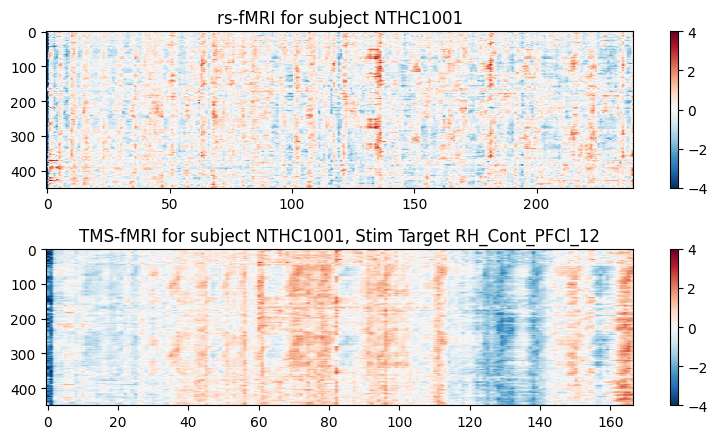

In [84]:
from scipy import stats
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4.5))
plt.subplot(2,1,1)
plt.title('rs-fMRI for subject %s'%subjects_all[sid])
plt.imshow(stats.zscore(rest_ex).T, 
           aspect='auto',cmap='RdBu_r',vmax=4,vmin=-4)
plt.colorbar()
plt.subplot(2,1,2)
plt.title('TMS-fMRI for subject %s, Stim Target %s'%(subjects_all[sid],target_label))
plt.imshow(stats.zscore(task_ex).T, 
           aspect='auto',cmap='RdBu_r',vmax=4,vmin=-4)
plt.colorbar()
plt.tight_layout()
plt.show()

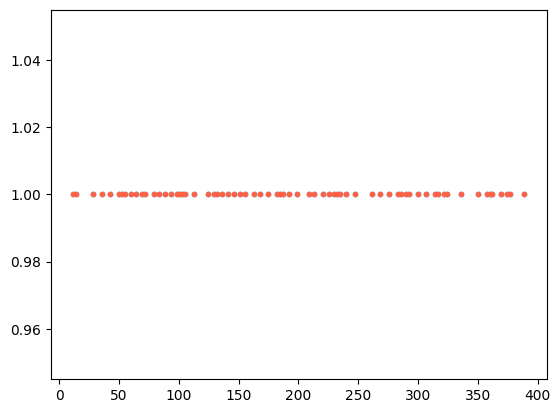

In [75]:
stimt=dataset['sub-'+subjects_all[sid]]['task-stim'][0]['stim time']['onset']
plt.plot(stimt,np.ones(len(stimt)),'.')
stimt=dataset['sub-'+subjects_all[10]]['task-stim'][0]['stim time']['onset']
plt.plot(stimt,np.ones(len(stimt)),'.',c='tomato')

In [68]:
dataset['sub-'+subjects_all[sid]]['task-stim'][0]['stim time']['onset']

0      11.8
1      14.2
2      28.6
3      35.8
4      43.0
      ...  
63    362.2
64    369.4
65    374.2
66    376.6
67    388.6
Name: onset, Length: 68, dtype: float64

In [60]:
nvol=dataset['sub-'+subjects_all[sid]]['task-stim'][0]['metadata']['n_volumes']

In [61]:
tr=dataset['sub-'+subjects_all[sid]]['task-stim'][0]['metadata']['tr_s']

In [67]:
np.linspace(0,tr*nvol,nvol+1)[:-1]

array([  0. ,   2.4,   4.8,   7.2,   9.6,  12. ,  14.4,  16.8,  19.2,
        21.6,  24. ,  26.4,  28.8,  31.2,  33.6,  36. ,  38.4,  40.8,
        43.2,  45.6,  48. ,  50.4,  52.8,  55.2,  57.6,  60. ,  62.4,
        64.8,  67.2,  69.6,  72. ,  74.4,  76.8,  79.2,  81.6,  84. ,
        86.4,  88.8,  91.2,  93.6,  96. ,  98.4, 100.8, 103.2, 105.6,
       108. , 110.4, 112.8, 115.2, 117.6, 120. , 122.4, 124.8, 127.2,
       129.6, 132. , 134.4, 136.8, 139.2, 141.6, 144. , 146.4, 148.8,
       151.2, 153.6, 156. , 158.4, 160.8, 163.2, 165.6, 168. , 170.4,
       172.8, 175.2, 177.6, 180. , 182.4, 184.8, 187.2, 189.6, 192. ,
       194.4, 196.8, 199.2, 201.6, 204. , 206.4, 208.8, 211.2, 213.6,
       216. , 218.4, 220.8, 223.2, 225.6, 228. , 230.4, 232.8, 235.2,
       237.6, 240. , 242.4, 244.8, 247.2, 249.6, 252. , 254.4, 256.8,
       259.2, 261.6, 264. , 266.4, 268.8, 271.2, 273.6, 276. , 278.4,
       280.8, 283.2, 285.6, 288. , 290.4, 292.8, 295.2, 297.6, 300. ,
       302.4, 304.8,

# CHECK ALIGNMENT PARCELS

In [11]:
import os, glob, re
from nilearn.image import load_img, index_img, resample_to_img
from nilearn import plotting

# =========================
# CONFIG
# =========================
BASE_DIR   = "/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI"
DERIV_DIR  = os.path.join(BASE_DIR, "derivatives")
SUBJECTS_TXT = os.path.join(BASE_DIR, "subjects_all.txt")

SCHAEFER_PATH = os.path.join(BASE_DIR, "atlases", "Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz")
TIAN_PATH     = os.path.join(BASE_DIR, "atlases", "Tian_Subcortex_S3_3T.nii")

# =========================
# LOAD SUBJECT LIST
# =========================
with open(SUBJECTS_TXT, "r") as f:
    subjects_all = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith("#")]

def to_bids_sub_id(sub_name):
    return sub_name if sub_name.startswith("sub-") else f"sub-{sub_name}"

# =========================
# FIND BOLD AUTOMATICALLY
# =========================
def find_bold_auto(sub_name, task="task-rest"):
    sub_id = to_bids_sub_id(sub_name)
    sub_dir = os.path.join(DERIV_DIR, sub_id)
    if not os.path.isdir(sub_dir):
        raise FileNotFoundError(f"Subject folder not found: {sub_dir}")

    patt = os.path.join(
        sub_dir, "ses-*", "func",
        f"*{task}*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    )
    hits = sorted(glob.glob(patt))
    if not hits:
        raise FileNotFoundError(f"No BOLD files found for {sub_id} with task={task}\nPattern:\n{patt}")

    bold_path = hits[0]
    ses_id = os.path.basename(os.path.dirname(os.path.dirname(bold_path)))

    stim_coords = None
    if task == "task-stim":
        fname = os.path.basename(bold_path)
        m = re.search(r"task-stim(\-?\d+)x(\-?\d+)x(\-?\d+)", fname)
        stim_coords = tuple(map(int, m.groups())) if m else None

    return bold_path, ses_id, stim_coords

# =========================
# PLOT ALIGNMENT (Schaefer + Tian, same cmap)
# =========================
def plot_alignment_auto(
    sub_name,
    task="task-rest",
    alpha_parcels=0.6,
    display_mode="ortho",
    cut_coords=(0, 0, 0),
    show_contours=True
):
    bold_path, ses_id, stim_coords = find_bold_auto(sub_name, task=task)

    bold_4d = load_img(bold_path)
    bold_3d = index_img(bold_4d, 0)

    sch = load_img(SCHAEFER_PATH)
    tian = load_img(TIAN_PATH)

    sch_rs = resample_to_img(sch, bold_3d, interpolation="nearest")
    tian_rs = resample_to_img(tian, bold_3d, interpolation="nearest")

    sub_id = to_bids_sub_id(sub_name)
    stim_str = f" | stim @ MNI {stim_coords}" if (task == "task-stim" and stim_coords is not None) else ""
    title = f"{sub_id} | {ses_id} | {task}{stim_str}\nfirst volume: {os.path.basename(bold_path)}"

    disp = plotting.plot_epi(
        bold_3d,
        cmap="gray",
        title=title,
        display_mode=display_mode,
        cut_coords=cut_coords,
        colorbar=False
    )

    # Same categorical cmap for BOTH atlases
    disp.add_overlay(sch_rs, cmap="tab20", transparency=alpha_parcels, colorbar=False)
    disp.add_overlay(tian_rs, cmap="tab20", transparency=alpha_parcels, colorbar=False)

    if show_contours:
        disp.add_contours(sch_rs, levels=[0.5], colors="black", linewidths=0.4)
        disp.add_contours(tian_rs, levels=[0.5], colors="black", linewidths=0.7)  # slightly thicker for subcortex

    plotting.show()

# Example:
# plot_alignment_auto(subjects_all[0], task="task-rest", cut_coords=(0,0,0))
# plot_alignment_auto(subjects_all[0], task="task-stim", cut_coords=(0,0,0))


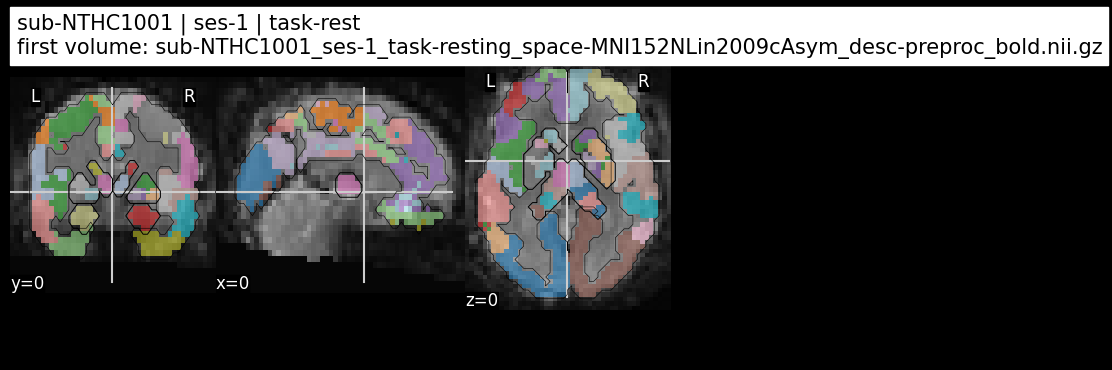

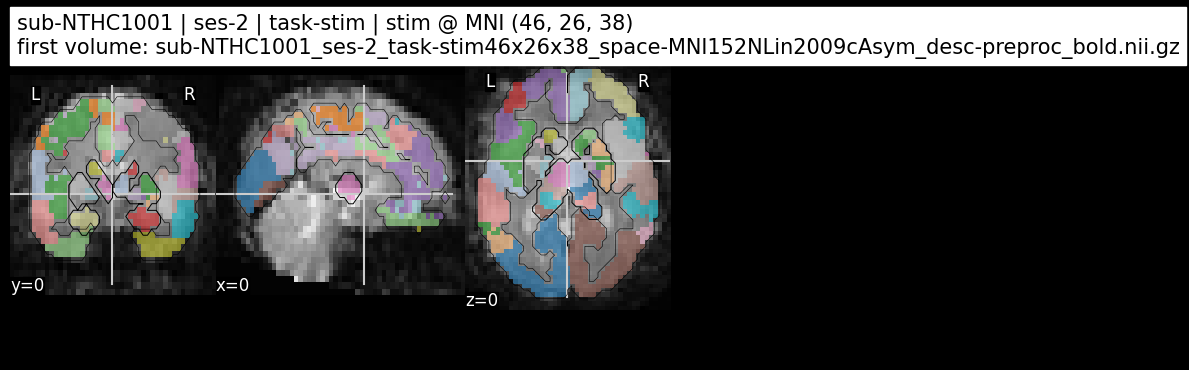

In [12]:
# =========================
# EXAMPLES
# =========================
plot_alignment_auto(subjects_all[0], task="task-rest", cut_coords=(0,0,0))
plot_alignment_auto(subjects_all[0], task="task-stim", cut_coords=(0,0,0))


# OLD (Just Schaefer)

In [5]:
# --- One-cell notebook: extract Schaefer-400 parcel time series + build nested dict with metadata ---

import os, re, glob, json
import numpy as np
import pandas as pd
import nibabel as nib

from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import load_img, resample_to_img

# =========================
# CONFIG
# =========================
BASE_DIR   = "/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI"
DERIV_DIR  = os.path.join(BASE_DIR, "derivatives")
ATLAS_PATH = os.path.join(BASE_DIR, "atlases/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz")
SUBJECTS_TXT = os.path.join(BASE_DIR, "subjects_all.txt")

# If these files exist in BASE_DIR, we use them; otherwise fall back to the uploaded sandbox versions.
EVENTS_PATH_CANDIDATES = [
    os.path.join(BASE_DIR, "task-stim_events.tsv"),
    "/mnt/data/task-stim_events.tsv",
]
PARTICIPANTS_PATH_CANDIDATES = [
    os.path.join(BASE_DIR, "participants.tsv"),
    "/mnt/data/participants.tsv",
]

# =========================
# LOAD SUBJECT LIST
# =========================
with open(SUBJECTS_TXT, "r") as f:
    subjects_all = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith("#")]

In [1]:
import nilearn
print(nilearn.__version__)

# =========================
# LOAD ATLAS INFO
# =========================

from nilearn.datasets import fetch_atlas_schaefer_2018

atlas = fetch_atlas_schaefer_2018(
    n_rois=400,
    yeo_networks=7,
    resolution_mm=2
)

0.13.0


In [3]:
# TR metadata from the dataset paper:
# - Resting state: TR = 2000 ms
# - TMS/fMRI: effective TR = 2400 ms (TR=2100 ms + 300 ms gap)
TR_REST_S  = 2.0
TR_STIM_S  = 2.4
TR_STIM_ACTUAL_S = 2.1
TR_STIM_GAP_S    = 0.3

# NiftiLabelsMasker defaults you can tweak
STANDARDIZE = True
DETREND     = True

# =========================
# HELPERS
# =========================
def first_existing(paths):
    for p in paths:
        if p and os.path.exists(p):
            return p
    return None

def load_json_if_exists(path):
    if path and os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None

def parse_task_and_coords_from_fname(fname):
    """
    Returns:
      task_type: "task-rest" or "task-stim"
      stim_coords: np.array([x,y,z]) or None
    """
    if "task-rest" in fname:
        return "task-rest", None
    if "task-stim" in fname:
        m = re.search(r"task-stim(\-?\d+)x(\-?\d+)x(\-?\d+)", fname)
        if not m:
            raise RuntimeError(f"Cannot parse stimulation coordinates from filename: {fname}")
        return "task-stim", np.array(list(map(int, m.groups())), dtype=int)
    return None, None

def stimulated_parcel_from_mni(atlas_img, mni_coord):
    """
    atlas_img: labels image in the same space/grid as BOLD (already resampled)
    mni_coord: array-like (x,y,z) in mm
    Returns: (stim_mask, label_int) or (None, None) if out-of-bounds or hits background
    """
    data = atlas_img.get_fdata()
    inv_aff = np.linalg.inv(atlas_img.affine)
    ijk = nib.affines.apply_affine(inv_aff, mni_coord)
    ijk = np.round(ijk).astype(int)

    if np.any(ijk < 0) or np.any(ijk >= np.array(data.shape)):
        return None, None

    label = int(data[tuple(ijk)])
    if label == 0:
        return None, None

    n_parcels = int(data.max())
    stim = np.zeros(n_parcels, dtype=int)
    stim[label - 1] = 1
    return stim, label

def find_bold_files(func_dir):
    """
    Finds MNI preproc BOLD files from fMRIPrep-style outputs.
    """
    patterns = [
        "*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz",
        "*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii",
    ]
    files = []
    for pat in patterns:
        files.extend(glob.glob(os.path.join(func_dir, pat)))
    return sorted(set(files))

def infer_tr_from_json(json_sidecar, fallback_tr):
    """
    Prefer RepetitionTime from sidecar if present (in seconds),
    otherwise fallback to provided TR.
    """
    if isinstance(json_sidecar, dict):
        rt = json_sidecar.get("RepetitionTime", None)
        if rt is not None:
            try:
                return float(rt)
            except Exception:
                pass
    return float(fallback_tr)


In [4]:
# =========================
# LOAD AUX FILES
# =========================
events_path = first_existing(EVENTS_PATH_CANDIDATES)
participants_path = first_existing(PARTICIPANTS_PATH_CANDIDATES)

stim_events = None
if events_path is not None:
    stim_events = pd.read_csv(events_path, sep="\t")

participants = None
if participants_path is not None:
    participants = pd.read_csv(participants_path, sep="\t")

if not os.path.exists(DERIV_DIR):
    raise FileNotFoundError(f"DERIV_DIR not found: {DERIV_DIR}")
if not os.path.exists(ATLAS_PATH):
    raise FileNotFoundError(f"Schaefer atlas not found: {ATLAS_PATH}")

atlas_img_native = load_img(ATLAS_PATH)

# EXTRACT DATASET

In [9]:
# =========================
# MAIN EXTRACTION
# =========================
dataset = {}

sub_dirs = sorted([p for p in glob.glob(os.path.join(DERIV_DIR, "sub-*")) if os.path.isdir(p)])

for sub_path in sub_dirs:
    sub_id = os.path.basename(sub_path)  # e.g., sub-NTHC1001
    print(sub_id)
    dataset[sub_id] = {}

    ses_dirs = sorted([p for p in glob.glob(os.path.join(sub_path, "ses-*")) if os.path.isdir(p)])
    for ses_path in ses_dirs:
        ses_id = os.path.basename(ses_path)  # e.g., ses-1
        func_dir = os.path.join(ses_path, "func")
        if not os.path.isdir(func_dir):
            continue

        bold_files = find_bold_files(func_dir)
        if not bold_files:
            continue

        for bold_file in bold_files:
            fname = os.path.basename(bold_file)

            task_type, stim_coords = parse_task_and_coords_from_fname(fname)
            if task_type is None:
                continue
            print(stim_coords)

            # sidecar JSON (if present) typically matches bold file prefix
            json_sidecar_path = bold_file.replace(".nii.gz", ".json").replace(".nii", ".json")
            sidecar = load_json_if_exists(json_sidecar_path)

            # Assign TR by task using paper-derived values, but allow sidecar to override
            if task_type == "task-rest":
                tr_fallback = TR_REST_S
                tr_seconds = infer_tr_from_json(sidecar, tr_fallback)
                metadata = {
                    "subject": sub_id,
                    "session": ses_id,
                    "task": "rest",
                    "tr_s": tr_seconds,
                    "tr_source": "json_sidecar" if (isinstance(sidecar, dict) and sidecar.get("RepetitionTime", None) is not None) else "paper_value",
                    "bold_file": bold_file,
                    "bold_json": json_sidecar_path if os.path.exists(json_sidecar_path) else None,
                }
            else:
                # stimulation
                tr_fallback = TR_STIM_S  # effective TR expected by you
                tr_seconds = infer_tr_from_json(sidecar, tr_fallback)
                metadata = {
                    "subject": sub_id,
                    "session": ses_id,
                    "task": "stim",
                    "tr_s": tr_seconds,  # effective TR in your model/dict
                    "tr_effective_s": TR_STIM_S,
                    "tr_actual_s": TR_STIM_ACTUAL_S,
                    "tr_gap_s": TR_STIM_GAP_S,
                    "tr_source": "json_sidecar" if (isinstance(sidecar, dict) and sidecar.get("RepetitionTime", None) is not None) else "paper_value",
                    "stim_mni_xyz": stim_coords.tolist(),
                    "bold_file": bold_file,
                    "bold_json": json_sidecar_path if os.path.exists(json_sidecar_path) else None,
                }

            # Load BOLD, resample atlas to BOLD grid
            bold_img = load_img(bold_file)
            atlas_resampled = resample_to_img(atlas_img_native, bold_img, interpolation="nearest")

            # Extract parcel time series
            masker = NiftiLabelsMasker(
                labels_img=atlas_resampled,
                standardize=STANDARDIZE,
                detrend=DETREND,
                t_r=tr_seconds,
            )
            ts = masker.fit_transform(bold_img)  # shape: (T, N_parcels)

            # Add basic derived metadata
            metadata["n_volumes"] = int(ts.shape[0])
            metadata["n_parcels"]  = int(ts.shape[1])

            # Initialize nested dict
            if task_type not in dataset[sub_id]:
                dataset[sub_id][task_type] = {}

            if task_type == "task-rest":
                dataset[sub_id][task_type]["time series"] = ts
                dataset[sub_id][task_type]["metadata"] = metadata

            else:
                # Stim target mask from MNI coord -> atlas label
                stim_mask, stim_label = stimulated_parcel_from_mni(atlas_resampled, stim_coords)
                metadata["stim_parcel_label"] = int(stim_label) if stim_label is not None else None

                # Pull stim times for this subject/session, if events file has matching columns
                stim_times_df = None
                if stim_events is not None:
                    # Try a couple common column name conventions robustly
                    cols = {c.lower(): c for c in stim_events.columns}

                    # subject column
                    subj_col = cols.get("subject", None) or cols.get("sub", None) or cols.get("participant_id", None)
                    ses_col  = cols.get("session", None) or cols.get("ses", None)

                    df = stim_events.copy()
                    if subj_col is not None:
                        df = df[df[subj_col].astype(str) == sub_id]
                    if ses_col is not None:
                        df = df[df[ses_col].astype(str) == ses_id]

                    # If file only contains one subject/session, keep as-is
                    stim_times_df = df if len(df) else df

                dataset[sub_id][task_type]["time series"] = ts
                dataset[sub_id][task_type]["metadata"] = metadata
                dataset[sub_id][task_type]["target"] = stim_mask
                dataset[sub_id][task_type]["stim time"] = stim_times_df

sub-NTHC1001
None
[46 26 38]
sub-NTHC1003
None
[50 10 28]


In [10]:
# =========================
# DONE
# =========================
print(f"Built dataset for {len(dataset)} subjects.")
# Example peek:
some_sub = next(iter(dataset.keys()), None)
if some_sub:
    print("Example subject:", some_sub)
    print("Keys:", list(dataset[some_sub].keys()))
    for k in dataset[some_sub].keys():
        print(k, "-> subkeys:", list(dataset[some_sub][k].keys()))
        print(k, "metadata:", {kk: dataset[some_sub][k]['metadata'][kk] for kk in list(dataset[some_sub][k]['metadata'].keys())[:8]}, "...")


Built dataset for 2 subjects.
Example subject: sub-NTHC1001
Keys: ['task-rest', 'task-stim']
task-rest -> subkeys: ['time series', 'metadata']
task-rest metadata: {'subject': 'sub-NTHC1001', 'session': 'ses-1', 'task': 'rest', 'tr_s': 2.0, 'tr_source': 'json_sidecar', 'bold_file': '/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI/derivatives/sub-NTHC1001/ses-1/func/sub-NTHC1001_ses-1_task-resting_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'bold_json': '/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI/derivatives/sub-NTHC1001/ses-1/func/sub-NTHC1001_ses-1_task-resting_space-MNI152NLin2009cAsym_desc-preproc_bold.json', 'n_volumes': 240} ...
task-stim -> subkeys: ['time series', 'metadata', 'target', 'stim time']
task-stim metadata: {'subject': 'sub-NTHC1001', 'session': 'ses-2', 'task': 'stim', 'tr_s': 2.4, 'tr_effective_s': 2.4, 'tr_actual_s': 2.1, 'tr_gap_s': 0.3, 'tr_source': 'json_sidecar'} ...


# PLOT ROIs

In [68]:
sid=0
rest_ex=dataset['sub-'+subjects_all[sid]]['task-rest']['time series']
task_ex=dataset['sub-'+subjects_all[sid]]['task-stim']['time series']

In [26]:
target_id=np.where(dataset['sub-'+subjects_all[sid]]['task-stim']['target']==1)[0][0]
target_label=atlas['labels'][target_id]
target_label= target_label.decode("utf-8").removeprefix("7Networks_")

NameError: name 'atlas' is not defined

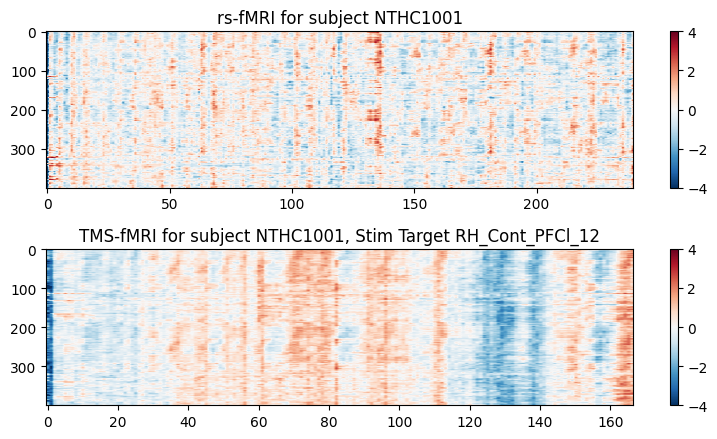

In [72]:
from scipy import stats
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4.5))
plt.subplot(2,1,1)
plt.title('rs-fMRI for subject %s'%subjects_all[sid])
plt.imshow(stats.zscore(rest_ex).T, 
           aspect='auto',cmap='RdBu_r',vmax=4,vmin=-4)
plt.colorbar()
plt.subplot(2,1,2)
plt.title('TMS-fMRI for subject %s, Stim Target %s'%(subjects_all[sid],target_label))
plt.imshow(stats.zscore(task_ex).T, 
           aspect='auto',cmap='RdBu_r',vmax=4,vmin=-4)
plt.colorbar()
plt.tight_layout()
plt.show()

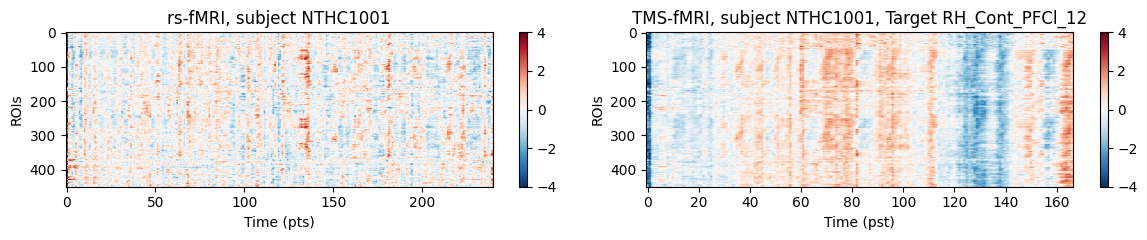

In [42]:
from scipy import stats
import matplotlib.pyplot as plt

plt.figure(figsize=(12,2.5))
plt.subplot(1,2,1)
plt.title('rs-fMRI, subject %s'%subjects_all[sid])
plt.imshow(zscore_using_reference(rest_ex,rest_ex)[0].T, 
           aspect='auto',cmap='RdBu_r',vmax=4,vmin=-4)
plt.xlabel('Time (pts)')
plt.ylabel('ROIs')
plt.colorbar()
plt.subplot(1,2,2)
plt.title('TMS-fMRI, subject %s, Target %s'%(subjects_all[sid],target_label))
plt.imshow(zscore_using_reference(rest_ex,task_ex)[0].T, 
           aspect='auto',cmap='RdBu_r',vmax=4,vmin=-4)
plt.xlabel('Time (pst)')
plt.ylabel('ROIs')
plt.colorbar()
plt.tight_layout()
plt.savefig('raster.pdf',transparent=True)
plt.show()

# CHECK ALIGNMENT PARCELS

In [41]:
import os, glob, re
from nilearn.image import load_img, index_img, resample_to_img
from nilearn import plotting

# =========================
# CONFIG
# =========================
BASE_DIR   = "/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI"
DERIV_DIR  = os.path.join(BASE_DIR, "derivatives")
SUBJECTS_TXT = os.path.join(BASE_DIR, "subjects_all.txt")
ATLAS_PATH = os.path.join(BASE_DIR, "Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz")

# =========================
# LOAD SUBJECT LIST
# =========================
with open(SUBJECTS_TXT, "r") as f:
    subjects_all = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith("#")]

# subjects_all contains like: ["NTHC1001", "NTHC1002", ...]
# We will internally map -> "sub-NTHC1001"
def to_bids_sub_id(sub_name):
    return sub_name if sub_name.startswith("sub-") else f"sub-{sub_name}"

# =========================
# FIND BOLD AUTOMATICALLY
# =========================
def find_bold_auto(sub_name, task="task-rest"):
    """
    sub_name: "NTHC1001" (from subjects_all) or "sub-NTHC1001"
    task: "task-rest" or "task-stim"
    Returns: (bold_path, ses_id, stim_coords_or_None)
    """
    sub_id = to_bids_sub_id(sub_name)
    sub_dir = os.path.join(DERIV_DIR, sub_id)
    if not os.path.isdir(sub_dir):
        raise FileNotFoundError(f"Subject folder not found: {sub_dir}")

    # Search all sessions/func for matching preproc BOLDs
    patt = os.path.join(
        sub_dir, "ses-*", "func",
        f"*{task}*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    )
    hits = sorted(glob.glob(patt))
    if not hits:
        raise FileNotFoundError(f"No BOLD files found for {sub_id} with task={task}\nPattern:\n{patt}")

    bold_path = hits[0]  # choose first match (usually only one per task/session)
    ses_id = os.path.basename(os.path.dirname(os.path.dirname(bold_path)))  # .../ses-*/func/file.nii.gz -> ses-*

    stim_coords = None
    if task == "task-stim":
        fname = os.path.basename(bold_path)
        m = re.search(r"task-stim(\-?\d+)x(\-?\d+)x(\-?\d+)", fname)
        if m:
            stim_coords = tuple(map(int, m.groups()))
        else:
            stim_coords = None

    return bold_path, ses_id, stim_coords

# =========================
# PLOT ALIGNMENT
# =========================
def plot_alignment_auto(
    sub_name,
    task="task-rest",
    alpha_parcels=0.6,
    display_mode="ortho",
    cut_coords=(0, 0, 0),
    show_contours=True
):
    """
    sub_name: e.g. subjects_all[0] -> "NTHC1001"
    task: "task-rest" or "task-stim"
    Automatically finds session + (if stim) parses MNI coords from filename and puts in title.
    """
    bold_path, ses_id, stim_coords = find_bold_auto(sub_name, task=task)

    # Load BOLD (first volume)
    bold_4d = load_img(bold_path)
    bold_3d = index_img(bold_4d, 0)

    # Load + resample atlas to BOLD grid
    atlas = load_img(ATLAS_PATH)
    atlas_rs = resample_to_img(atlas, bold_3d, interpolation="nearest")

    # Build title
    sub_id = to_bids_sub_id(sub_name)
    if task == "task-stim":
        stim_str = f" | stim @ MNI {stim_coords}" if stim_coords is not None else " | stim (coords not parsed)"
    else:
        stim_str = ""

    title = f"{sub_id} | {ses_id} | {task}{stim_str}\nfirst volume: {os.path.basename(bold_path)}"

    # Plot BOLD grayscale
    disp = plotting.plot_epi(
        bold_3d,
        cmap="gray",
        title=title,
        display_mode=display_mode,
        cut_coords=cut_coords,
        colorbar=False
    )

    # Overlay parcels categorical colors
    disp.add_overlay(
        atlas_rs,
        cmap="tab20",
        transparency=alpha_parcels,
        colorbar=False
    )

    # Optional parcel boundaries
    if show_contours:
        disp.add_contours(
            atlas_rs,
            levels=[0.5],
            colors="black",
            linewidths=0.5
        )

    plotting.show()

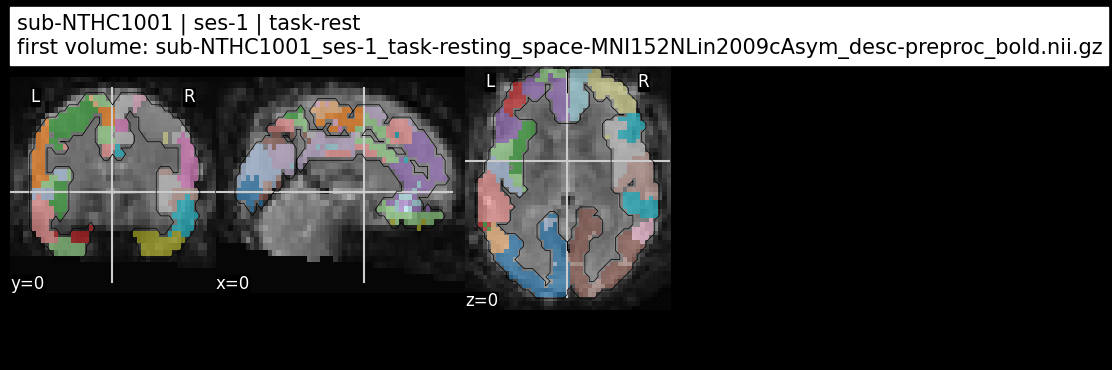

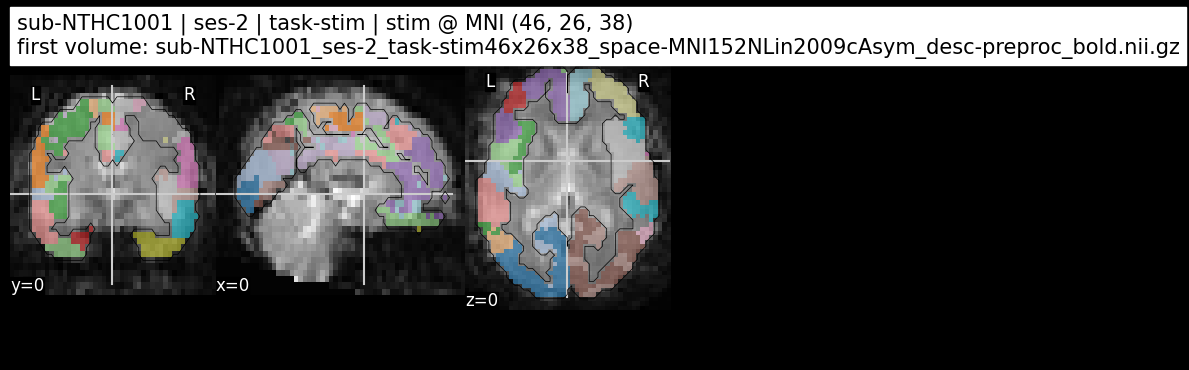

In [45]:
# =========================
# EXAMPLES
# =========================
plot_alignment_auto(subjects_all[0], task="task-rest", cut_coords=(0,0,0))
plot_alignment_auto(subjects_all[0], task="task-stim", cut_coords=(0,0,0))


# TEST BACKGROUND-DEPENDENCE

In [24]:
"""
State-energy vs stimulation effect (model-comparable) — FULL PIPELINE
====================================================================

You requested:
- Baseline at t=0 (i.e., use x_stim(t0) where t0 is the TR index corresponding to stim onset).
- Effect size uses ONLY post states (no x_stim(t0) in the distance term):
    effect_i(lag) = || x_stim(t0+lag) - x_hat_rest(t0+lag | x_base) ||_2
  where x_base is the baseline state (here: x_stim(t0) since baseline t=0).
- Avoid cosine distance.
- Add robustness checks.
- Also implement the key fix to recover your model-like anticorrelation:
    compute "excess effect" relative to REST expectation conditioned on baseline energy:
      excess_i = effect_stim_i - E_rest[effect | E in same energy bin]

What you will get:
1) Raw correlations: corr(E_base, effect_stim)
2) "Excess" correlations: corr(E_base, excess_effect)  (this is the one most comparable to model)
3) Ratio correlations: corr(E_base, effect_stim / expected_rest_effect_at_same_energy)
4) Null checks:
   - REST fake events correlations (should not reproduce stimulation-specific structure)
5) Robustness:
   - lag sweep (lag=1..max_lag)
   - predictor robustness: kNN and Ridge-VAR(1)
   - permutation p-value + bootstrap CI for key correlations

Assumptions about your dataset object:
- dataset[f"sub-{sub}"]["task-rest"]["time series"] -> (Trest, R)
- dataset[f"sub-{sub}"]["task-stim"]["time series"] -> (Tstim, R)
- dataset[f"sub-{sub}"]["task-stim"]["stim time"] has column "onset" in seconds

If you want baseline offset variants later (e.g. -1, -2), it's a one-line change.
"""

import numpy as np
from scipy.stats import spearmanr, pearsonr
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import Ridge


# ----------------------------
# Utilities
# ----------------------------

def zscore_using_reference(X_ref: np.ndarray, X: np.ndarray):
    """Z-score X using mean/std computed from X_ref (per region)."""
    mu = X_ref.mean(axis=0)
    sd = X_ref.std(axis=0, ddof=0)
    sd = np.where(sd == 0, 1.0, sd)
    return (X - mu) / sd, mu, sd

def energy_vec(X: np.ndarray) -> np.ndarray:
    """Energy per timepoint: sum(z^2) across regions."""
    return np.sum(X**2, axis=1)

def corr(x, y, method="spearman"):
    if method == "spearman":
        r, p = spearmanr(x, y)
    elif method == "pearson":
        r, p = pearsonr(x, y)
    else:
        raise ValueError("method must be 'spearman' or 'pearson'")
    return float(r), float(p)

def bootstrap_corr(x, y, method="spearman", n_boot=2000, seed=0):
    rng = np.random.default_rng(seed)
    n = len(x)
    rs = np.empty(n_boot, dtype=float)
    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)
        rs[b] = corr(x[idx], y[idx], method=method)[0]
    rs.sort()
    lo = rs[int(0.025 * n_boot)]
    hi = rs[int(0.975 * n_boot)]
    return float(lo), float(hi)

def permutation_pvalue(x, y, method="spearman", n_perm=2000, seed=0):
    rng = np.random.default_rng(seed)
    r_obs = corr(x, y, method=method)[0]
    count = 0
    for _ in range(n_perm):
        yp = rng.permutation(y)
        r = corr(x, yp, method=method)[0]
        if abs(r) >= abs(r_obs):
            count += 1
    p = (count + 1) / (n_perm + 1)
    return float(r_obs), float(p)

def onset_to_index(onsets_sec: np.ndarray, TR: float) -> np.ndarray:
    """Convert onset seconds to nearest TR index."""
    return np.rint(onsets_sec / TR).astype(int)

def filter_valid_events(k0: np.ndarray, T: int, baseline_offset: int, max_lag: int):
    """Keep events where baseline and all post lags exist."""
    kb = k0 + baseline_offset
    ok = (kb >= 0) & (k0 + max_lag < T)
    return k0[ok], ok


# ----------------------------
# Counterfactual predictors from REST
# ----------------------------

class KNNConditionalPredictor:
    """
    Nonparametric conditional expectation from rest:
      x_hat(t+lag | x_t) = weighted average of rest x(u+lag) for rest x(u) near x_t
    """
    def __init__(self, X_rest: np.ndarray, max_lag: int, k: int = 50, metric="euclidean"):
        self.Xr = X_rest
        self.max_lag = int(max_lag)
        self.k = int(k)
        self.metric = metric

        T = X_rest.shape[0]
        # Inputs must have room for max_lag forward
        self.inputs = X_rest[: T - self.max_lag]
        self.targets = {lag: X_rest[lag: lag + (T - self.max_lag)] for lag in range(1, self.max_lag + 1)}

        self.nn = NearestNeighbors(n_neighbors=min(self.k, len(self.inputs)), metric=self.metric)
        self.nn.fit(self.inputs)

    def predict(self, x_t: np.ndarray, lag: int) -> np.ndarray:
        lag = int(lag)
        dists, idx = self.nn.kneighbors(x_t.reshape(1, -1), return_distance=True)
        dists = dists.ravel()
        idx = idx.ravel()

        Y = self.targets[lag][idx]
        w = 1.0 / (dists + 1e-8)
        w = w / w.sum()
        return (w[:, None] * Y).sum(axis=0)

class RidgeVAR1Predictor:
    """
    Parametric check:
      x(t+1) = A x(t) + b  (fit on rest with ridge)
    Predict lag>1 by iterating.
    """
    def __init__(self, X_rest: np.ndarray, alpha: float = 10.0):
        self.model = Ridge(alpha=float(alpha), fit_intercept=True)
        self.model.fit(X_rest[:-1], X_rest[1:])

    def predict(self, x_t: np.ndarray, lag: int) -> np.ndarray:
        x = x_t.reshape(1, -1)
        for _ in range(int(lag)):
            x = self.model.predict(x)
        return x.ravel()


# ----------------------------
# Energy-conditioned "excess" correction
# ----------------------------

def expected_rest_effect_by_energy_bins(E_rest, eff_rest, E_query, n_bins=10, min_bin_n=30):
    """
    Estimate expected rest effect as a function of energy using quantile bins on REST.
    Returns expected values for each E_query (nan if bin too small).
    Uses median within bin (robust).
    """
    edges = np.quantile(E_rest, np.linspace(0, 1, n_bins + 1))
    edges = np.unique(edges)
    if len(edges) < 4:
        raise ValueError("Not enough unique energies in REST to build bins.")

    rest_bin = np.digitize(E_rest, edges[1:-1], right=True)
    query_bin = np.digitize(E_query, edges[1:-1], right=True)

    exp = np.full_like(E_query, np.nan, dtype=float)
    for b in range(query_bin.max() + 1):
        vals = eff_rest[rest_bin == b]
        if len(vals) >= min_bin_n:
            exp[query_bin == b] = np.median(vals)
    return exp


# ----------------------------
# Core: compute energies & effects for STIM and REST
# ----------------------------

def compute_effects_for_events(
    X_rest_z: np.ndarray,
    X_run_z: np.ndarray,
    k0: np.ndarray,
    baseline_offset: int,
    max_lag: int,
    knn_k: int,
):
    """
    For a given run (stim or rest) and event indices k0:
    - baseline state index kb = k0 + baseline_offset
    - baseline energy E = ||x(kb)||^2
    - for each lag: effect_knn, effect_var
    """
    kb = k0 + baseline_offset
    E = np.sum(X_run_z[kb] ** 2, axis=1)

    knn = KNNConditionalPredictor(X_rest_z, max_lag=max_lag, k=knn_k)
    var = RidgeVAR1Predictor(X_rest_z, alpha=10.0)

    effects_knn = {}
    effects_var = {}

    for lag in range(1, max_lag + 1):
        obs = X_run_z[k0 + lag]
        hats_knn = np.vstack([knn.predict(X_run_z[b], lag=lag) for b in kb])
        hats_var = np.vstack([var.predict(X_run_z[b], lag=lag) for b in kb])

        effects_knn[lag] = np.linalg.norm(obs - hats_knn, axis=1)
        effects_var[lag] = np.linalg.norm(obs - hats_var, axis=1)

    return E, effects_knn, effects_var


def sample_fake_events_in_rest(T: int, n_events: int, baseline_offset: int, max_lag: int, min_sep: int, seed=0):
    """
    Sample fake event indices k0 in REST with a minimum separation (in TRs).
    """
    rng = np.random.default_rng(seed)
    # valid range
    k_min = max(0, -baseline_offset)
    k_max = T - max_lag - 1
    candidates = np.arange(k_min, k_max + 1)
    rng.shuffle(candidates)

    chosen = []
    for k in candidates:
        if len(chosen) >= n_events:
            break
        if all(abs(k - c) >= min_sep for c in chosen):
            chosen.append(k)

    # fallback if too strict
    if len(chosen) < max(10, n_events // 2):
        chosen = rng.choice(candidates, size=min(n_events, len(candidates)), replace=False).tolist()

    chosen = np.array(sorted(chosen), dtype=int)
    return chosen


# ----------------------------
# Main analysis
# ----------------------------

def run_subject_analysis(
    dataset,
    subjects_all,
    sid: int,
    TR_rest: float = 2.0,
    TR_stim: float = 2.4,
    baseline_offset: int = 0,   # <-- you requested baseline t=0
    max_lag: int = 4,
    knn_k: int = 50,
    corr_method: str = "spearman",
    n_bins: int = 10,
    seed: int = 0,
):
    sub = subjects_all[sid]
    X_rest = dataset[f"sub-{sub}"]["task-rest"]["time series"]
    X_stim = dataset[f"sub-{sub}"]["task-stim"]["time series"]
    stim_df = dataset[f"sub-{sub}"]["task-stim"]["stim time"]
    onsets_sec = np.asarray(stim_df["onset"], dtype=float)

    # Z-score both runs using REST baseline (recommended)
    Xr_z, mu, sd = zscore_using_reference(X_rest, X_rest)
    Xs_z, _, _ = zscore_using_reference(X_rest, X_stim)

    # Stim event indices
    k0_all = onset_to_index(onsets_sec, TR_stim)
    k0, ok_mask = filter_valid_events(k0_all, T=Xs_z.shape[0], baseline_offset=baseline_offset, max_lag=max_lag)
    n_events = len(k0)
    if n_events < 10:
        raise ValueError(f"Too few valid stim events: {n_events}")

    # Compute STIM energies & effects
    E_stim, eff_stim_knn, eff_stim_var = compute_effects_for_events(
        X_rest_z=Xr_z,
        X_run_z=Xs_z,
        k0=k0,
        baseline_offset=baseline_offset,
        max_lag=max_lag,
        knn_k=knn_k,
    )

    # Build REST pseudo-events for conditioning and null checks
    # Use separation roughly similar to stim (~6 TR_stim apart) converted to rest TRs
    min_sep_sec = 6 * TR_stim
    min_sep_rest_tr = int(np.ceil(min_sep_sec / TR_rest))

    k0_rest = sample_fake_events_in_rest(
        T=Xr_z.shape[0],
        n_events=n_events,
        baseline_offset=baseline_offset,
        max_lag=max_lag,
        min_sep=min_sep_rest_tr,
        seed=seed + 10,
    )

    E_rest, eff_rest_knn, eff_rest_var = compute_effects_for_events(
        X_rest_z=Xr_z,
        X_run_z=Xr_z,
        k0=k0_rest,
        baseline_offset=baseline_offset,
        max_lag=max_lag,
        knn_k=knn_k,
    )

    # Summaries per lag
    per_lag = {}
    for lag in range(1, max_lag + 1):
        out = {}

        # --- RAW correlation (often dominated by intrinsic energy->unpredictability)
        r_raw, p_raw = corr(E_stim, eff_stim_knn[lag], method=corr_method)
        r_raw_var, p_raw_var = corr(E_stim, eff_stim_var[lag], method=corr_method)

        # --- Energy-conditioned expected REST effect (key step)
        exp_rest = expected_rest_effect_by_energy_bins(
            E_rest=E_rest,
            eff_rest=eff_rest_knn[lag],
            E_query=E_stim,
            n_bins=n_bins,
            min_bin_n=max(20, n_events // (2 * n_bins)),
        )
        valid = np.isfinite(exp_rest)
        if valid.sum() < max(10, n_events // 2):
            # if too many NaNs, relax bins a bit
            exp_rest = expected_rest_effect_by_energy_bins(
                E_rest=E_rest,
                eff_rest=eff_rest_knn[lag],
                E_query=E_stim,
                n_bins=max(6, n_bins // 2),
                min_bin_n=10,
            )
            valid = np.isfinite(exp_rest)

        excess = eff_stim_knn[lag][valid] - exp_rest[valid]
        ratio = eff_stim_knn[lag][valid] / (exp_rest[valid] + 1e-8)

        # correlations after removing intrinsic energy dependence
        r_ex, p_ex = corr(E_stim[valid], excess, method=corr_method)
        r_ra, p_ra = corr(E_stim[valid], ratio, method=corr_method)

        # basic: is excess > 0 overall? (stimulation increases deviations)
        excess_mean = float(np.mean(excess))
        excess_med = float(np.median(excess))

        # robustness: permutation p-value for the EXCESS correlation (most important)
        r_obs_perm, p_perm = permutation_pvalue(E_stim[valid], excess, method=corr_method, n_perm=2000, seed=seed + 100 + lag)
        ci_lo, ci_hi = bootstrap_corr(E_stim[valid], excess, method=corr_method, n_boot=2000, seed=seed + 200 + lag)

        # REST-null check: does E_rest correlate with rest prediction error?
        r_restnull, p_restnull = corr(E_rest, eff_rest_knn[lag], method=corr_method)

        out.update({
            "n_events": n_events,
            "n_valid_excess": int(valid.sum()),
            "raw_knn": {"r": r_raw, "p": p_raw},
            "raw_var": {"r": r_raw_var, "p": p_raw_var},
            "rest_null": {"r": r_restnull, "p": p_restnull},
            "excess": {
                "r": r_ex, "p": p_ex,
                "perm_p": p_perm,
                "ci95": (ci_lo, ci_hi),
                "mean": excess_mean,
                "median": excess_med,
            },
            "ratio": {"r": r_ra, "p": p_ra},
        })

        per_lag[lag] = out

    return {
        "subject": sub,
        "TR_rest": TR_rest,
        "TR_stim": TR_stim,
        "baseline_offset": baseline_offset,
        "baseline_definition": "t=0 (x_stim at onset index)",
        "zscore_reference": "rest",
        "n_events": n_events,
        "per_lag": per_lag,
        "arrays": {
            "k0_stim": k0,
            "E_stim": E_stim,
            "E_rest": E_rest,
            "eff_stim_knn": eff_stim_knn,
            "eff_rest_knn": eff_rest_knn,
        }
    }


def print_results_summary(res):
    print(f"Subject: {res['subject']}")
    print(f"TR_rest={res['TR_rest']}  TR_stim={res['TR_stim']}")
    print(f"Baseline: {res['baseline_definition']} (baseline_offset={res['baseline_offset']})")
    print(f"Z-score reference: {res['zscore_reference']}")
    print(f"n_events: {res['n_events']}")
    print()

    for lag, out in res["per_lag"].items():
        raw = out["raw_knn"]
        rawv = out["raw_var"]
        ex = out["excess"]
        rn = out["rest_null"]
        ra = out["ratio"]

        print(f"lag={lag}:")
        print(f"  RAW corr(E, effect):      KNN r={raw['r']:+.3f} p={raw['p']:.3g} | VAR r={rawv['r']:+.3f} p={rawv['p']:.3g}")
        print(f"  REST null corr(E, err):    r={rn['r']:+.3f} p={rn['p']:.3g}")
        print(f"  EXCESS corr(E, excess):    r={ex['r']:+.3f} p={ex['p']:.3g} perm_p={ex['perm_p']:.3g} CI95=[{ex['ci95'][0]:+.3f},{ex['ci95'][1]:+.3f}]")
        print(f"  Excess mean/median:        mean={ex['mean']:+.4f}  median={ex['median']:+.4f}  (n_valid={out['n_valid_excess']})")
        print(f"  RATIO corr(E, ratio):      r={ra['r']:+.3f} p={ra['p']:.3g}")
        print()

In [25]:
# ----------------------------
# USAGE
# ----------------------------
res = run_subject_analysis(dataset, subjects_all, sid=0,
                           baseline_offset=0,   # baseline t=0 (your request)
                           max_lag=4, knn_k=50,
                           corr_method="spearman",
                           n_bins=10, seed=0)
print_results_summary(res)

"""
How to interpret for your model anticorrelation:
- Look at EXCESS corr(E, excess). If your model predicts anticorrelation, you want this r to be NEGATIVE.
- If RAW is positive but EXCESS becomes negative, that's the classic "intrinsic instability masking the true stimulation effect".
- Also check excess mean/median:
    if >0, stimulation increases deviations above rest expectation (at matched energy).
    if ~0, stimulation isn't increasing deviations beyond rest-like unpredictability.
"""


Subject: NTHC1001
TR_rest=2.0  TR_stim=2.4
Baseline: t=0 (x_stim at onset index) (baseline_offset=0)
Z-score reference: rest
n_events: 68

lag=1:
  RAW corr(E, effect):      KNN r=+0.596 p=8.47e-08 | VAR r=+0.634 p=6.39e-09
  REST null corr(E, err):    r=+0.152 p=0.215
  EXCESS corr(E, excess):    r=+0.596 p=8.47e-08 perm_p=0.0005 CI95=[+0.399,+0.743]
  Excess mean/median:        mean=+16.2575  median=+14.6055  (n_valid=68)
  RATIO corr(E, ratio):      r=+0.408 p=0.000546

lag=2:
  RAW corr(E, effect):      KNN r=+0.426 p=0.000295 | VAR r=+0.532 p=3.02e-06
  REST null corr(E, err):    r=+0.081 p=0.514
  EXCESS corr(E, excess):    r=+0.426 p=0.000295 perm_p=0.0015 CI95=[+0.208,+0.608]
  Excess mean/median:        mean=+19.2114  median=+18.1338  (n_valid=68)
  RATIO corr(E, ratio):      r=+0.423 p=0.000322

lag=3:
  RAW corr(E, effect):      KNN r=+0.290 p=0.0165 | VAR r=+0.401 p=0.000705
  REST null corr(E, err):    r=+0.049 p=0.691
  EXCESS corr(E, excess):    r=+0.290 p=0.0165 perm_p=

'\nHow to interpret for your model anticorrelation:\n- Look at EXCESS corr(E, excess). If your model predicts anticorrelation, you want this r to be NEGATIVE.\n- If RAW is positive but EXCESS becomes negative, that\'s the classic "intrinsic instability masking the true stimulation effect".\n- Also check excess mean/median:\n    if >0, stimulation increases deviations above rest expectation (at matched energy).\n    if ~0, stimulation isn\'t increasing deviations beyond rest-like unpredictability.\n'

# OLD CODE 

In [ ]:
# --- Setup cell ---

# 1 - Mount Drive (for data only)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2 - Clone repo (only if missing)
import os
if not os.path.exists("/content/BrainStim_ANN_fMRI_HCP"):
    !git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git
else:
    print("Repo already exists ✅")

# 3 - Set paths
repo_dir = "/content/BrainStim_ANN_fMRI_HCP"
data_dir = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"

import sys
sys.path.append(repo_dir)

# 4 - Imports
from src.preprocessing_hcp import *
from src.NPI import *

import numpy as np
import matplotlib.pyplot as plt
import h5py
import gc

print("✅ Environment ready!")
print("Repo directory:", repo_dir)
print("Data directory:", data_dir)

Mounted at /content/drive
Repo already exists ✅
✅ Environment ready!
Repo directory: /content/BrainStim_ANN_fMRI_HCP
Data directory: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data


In [ ]:
# --- Preprocessing and data extraction ---

# Parameters
n_nodes = 450                # number of brain regions (parcels)
remove_points = 30           # remove first 30 TRs
using_steps = 3              # window length for multi2one
number_of_subjects = 10      # or 996 if all subjects
dtype = np.float32

# ------------------------------------------------------------------------------
# 1 - Locate fMRI run files
# ------------------------------------------------------------------------------

run_files = {
    "REST1_LR": os.path.join(data_dir, "fmri/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3_REST1_LR.mat"),
    "REST1_RL": os.path.join(data_dir, "fmri/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3_REST1_RL.mat"),
    "REST2_LR": os.path.join(data_dir, "fmri/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3_REST2_LR.mat"),
    "REST2_RL": os.path.join(data_dir, "fmri/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3_REST2_RL.mat")
}
run_order = list(run_files.keys())

print(f"✅ Found {len(run_files)} fMRI runs:")
for k in run_order:
    print("  -", k)

✅ Found 4 fMRI runs:
  - REST1_LR
  - REST1_RL
  - REST2_LR
  - REST2_RL


In [ ]:
# ------------------------------------------------------------------------------
# 2 - Find common subjects across runs
# ------------------------------------------------------------------------------

def list_subjects(h5path, run_key):
    """Return list of subjects for a given run file."""
    with h5py.File(h5path, "r") as f:
        return sorted(f["HCP"][run_key].keys(), key=lambda k: int(k.split("_")[-1]))

subject_sets = [set(list_subjects(run_files[k], k)) for k in run_order]
subject_ids = sorted(set.intersection(*subject_sets), key=lambda k: int(k.split("_")[-1]))

print(f"\n✅ Found {len(subject_ids)} subjects present in all runs.")
subject_ids = subject_ids[:number_of_subjects]
print(f"   → Will process first {len(subject_ids)} subjects.\n")


✅ Found 996 subjects present in all runs.
   → Will process first 10 subjects.



In [ ]:
# ------------------------------------------------------------------------------
# 3 - Process each subject
# ------------------------------------------------------------------------------

save_dir = os.path.join(data_dir, "preprocessed_subjects")
os.makedirs(save_dir, exist_ok=True)

for sid in subject_ids:
    print(f"🚀 Processing subject {sid}")
    subj_runs = []

    for run_key in run_order:
        # Load fMRI time series (T, N)
        with h5py.File(run_files[run_key], "r") as f:
            ts = f["HCP"][run_key][sid]["ts"][()]

        # Print shape before and after possible transpose
        print(f"      Original shape for {run_key}: {ts.shape}", end="")
        if ts.shape[0] < ts.shape[1]:
            ts = ts.T
            print(f" → Transposed to {ts.shape}")
        else:
            print(" (kept as is)")

        # Remove first 30 time points
        ts = ts[remove_points:, :n_nodes]

        # Apply bandpass filtering
        ts_filt = bandpass_filter_timeseries(ts)
        subj_runs.append(ts_filt)

        # Free memory from this run
        del ts, ts_filt
        gc.collect()

    # Concatenate all runs → (T_total, N)
    signals = np.concatenate(subj_runs, axis=0)
    print(f"   → Signals shape: {signals.shape}")

    # Create inputs and targets
    inputs, targets = multi2one(signals, steps=using_steps)
    print(f"   → Inputs: {inputs.shape}, Targets: {targets.shape}")

    # Save to disk
    np.save(os.path.join(save_dir, f"{sid}_signals.npy"), signals)
    np.save(os.path.join(save_dir, f"{sid}_inputs.npy"), inputs)
    np.save(os.path.join(save_dir, f"{sid}_targets.npy"), targets)
    print(f"   ✅ Saved preprocessed data for {sid}\n")

    # Cleanup
    del subj_runs, signals, inputs, targets
    gc.collect()

print("🎯 All subjects processed successfully!")
print(f"📂 Saved results in: {save_dir}")

🚀 Processing subject id_100206
      Original shape for REST1_LR: (1200, 450) (kept as is)
      Original shape for REST1_RL: (1200, 450) (kept as is)
      Original shape for REST2_LR: (1200, 450) (kept as is)
      Original shape for REST2_RL: (1200, 450) (kept as is)
   → Signals shape: (4680, 450)
   → Inputs: (4677, 1350), Targets: (4677, 450)
   ✅ Saved preprocessed data for id_100206

🚀 Processing subject id_100307
      Original shape for REST1_LR: (1200, 450) (kept as is)
      Original shape for REST1_RL: (1200, 450) (kept as is)
      Original shape for REST2_LR: (1200, 450) (kept as is)
      Original shape for REST2_RL: (1200, 450) (kept as is)
   → Signals shape: (4680, 450)
   → Inputs: (4677, 1350), Targets: (4677, 450)
   ✅ Saved preprocessed data for id_100307

🚀 Processing subject id_100408
      Original shape for REST1_LR: (1200, 450) (kept as is)
      Original shape for REST1_RL: (1200, 450) (kept as is)
      Original shape for REST2_LR: (1200, 450) (kept as is)

In [7]:
# =========================
# MAIN EXTRACTION
# =========================
dataset = {}

sub_dirs = sorted([p for p in glob.glob(os.path.join(DERIV_DIR, "sub-*")) if os.path.isdir(p)])

for sub_path in sub_dirs:
    sub_id = os.path.basename(sub_path)  # e.g., sub-NTHC1001
    print(sub_id)
    dataset[sub_id] = {}

    ses_dirs = sorted([p for p in glob.glob(os.path.join(sub_path, "ses-*")) if os.path.isdir(p)])
    for ses_path in ses_dirs:
        ses_id = os.path.basename(ses_path)  # e.g., ses-1
        func_dir = os.path.join(ses_path, "func")
        if not os.path.isdir(func_dir):
            continue

        bold_files = find_bold_files(func_dir)
        if not bold_files:
            continue

        for bold_file in bold_files:
            fname = os.path.basename(bold_file)

            task_type, stim_coords = parse_task_and_coords_from_fname(fname)
            if task_type is None:
                continue
            print(stim_coords)

            json_sidecar_path = bold_file.replace(".nii.gz", ".json").replace(".nii", ".json")
            sidecar = load_json_if_exists(json_sidecar_path)

            if task_type == "task-rest":
                tr_seconds = infer_tr_from_json(sidecar, TR_REST_S)
                metadata = {
                    "subject": sub_id,
                    "session": ses_id,
                    "task": "rest",
                    "tr_s": tr_seconds,
                    "tr_source": "json_sidecar" if (isinstance(sidecar, dict) and sidecar.get("RepetitionTime", None) is not None) else "paper_value",
                    "bold_file": bold_file,
                    "bold_json": json_sidecar_path if os.path.exists(json_sidecar_path) else None,
                }
            else:
                tr_seconds = infer_tr_from_json(sidecar, TR_STIM_S)
                metadata = {
                    "subject": sub_id,
                    "session": ses_id,
                    "task": "stim",
                    "tr_s": tr_seconds,
                    "tr_effective_s": TR_STIM_S,
                    "tr_actual_s": TR_STIM_ACTUAL_S,
                    "tr_gap_s": TR_STIM_GAP_S,
                    "tr_source": "json_sidecar" if (isinstance(sidecar, dict) and sidecar.get("RepetitionTime", None) is not None) else "paper_value",
                    "stim_mni_xyz": stim_coords.tolist(),
                    "bold_file": bold_file,
                    "bold_json": json_sidecar_path if os.path.exists(json_sidecar_path) else None,
                }

            # Load BOLD
            bold_img = load_img(bold_file)

            # Resample BOTH atlases to BOLD grid
            tian_resampled     = resample_to_img(tian_img_native,     bold_img, interpolation="nearest")
            schaefer_resampled = resample_to_img(schaefer_img_native, bold_img, interpolation="nearest")

            # Extract parcel time series (TIAN first, then SCHAEFER)
            masker_tian = NiftiLabelsMasker(
                labels_img=tian_resampled,
                standardize=STANDARDIZE,
                detrend=DETREND,
                t_r=tr_seconds,
            )
            masker_schaefer = NiftiLabelsMasker(
                labels_img=schaefer_resampled,
                standardize=STANDARDIZE,
                detrend=DETREND,
                t_r=tr_seconds,
            )

            ts_tian = masker_tian.fit_transform(bold_img)       # (T, 50)
            ts_sch  = masker_schaefer.fit_transform(bold_img)   # (T, 400)

            ts = np.concatenate([ts_tian, ts_sch], axis=1)      # (T, 450)

            # Add metadata
            metadata["n_volumes"] = int(ts.shape[0])
            metadata["n_parcels"] = int(ts.shape[1])
            metadata["n_tian"] = int(ts_tian.shape[1])
            metadata["n_schaefer"] = int(ts_sch.shape[1])
            metadata["atlas_order"] = "Tian50_then_Schaefer400"
            metadata["tian_labels_file"] = TIAN_LABELS

            # Initialize nested dict
            if task_type not in dataset[sub_id]:
                dataset[sub_id][task_type] = {}

            if task_type == "task-rest":
                dataset[sub_id][task_type]["time series"] = ts
                dataset[sub_id][task_type]["metadata"] = metadata

            else:
                # For targets: stim coords are cortical; build Schaefer target and embed into 450 vector (Tian first => zeros there)
                sch_mask, sch_label = stimulated_parcel_from_mni(schaefer_resampled, stim_coords, n_parcels_expected=int(ts_sch.shape[1]))
                metadata["stim_schaefer_label"] = int(sch_label) if sch_label is not None else None

                target_450 = np.zeros(ts.shape[1], dtype=int)
                if sch_mask is not None:
                    target_450[ts_tian.shape[1]:] = sch_mask  # put Schaefer mask after the first 50 Tian entries

                # Pull stim times
                stim_times_df = None
                if stim_events is not None:
                    cols = {c.lower(): c for c in stim_events.columns}
                    subj_col = cols.get("subject", None) or cols.get("sub", None) or cols.get("participant_id", None)
                    ses_col  = cols.get("session", None) or cols.get("ses", None)

                    df = stim_events.copy()
                    if subj_col is not None:
                        df = df[df[subj_col].astype(str) == sub_id]
                    if ses_col is not None:
                        df = df[df[ses_col].astype(str) == ses_id]
                    stim_times_df = df

                dataset[sub_id][task_type]["time series"] = ts
                dataset[sub_id][task_type]["metadata"] = metadata
                dataset[sub_id][task_type]["target"] = target_450
                dataset[sub_id][task_type]["stim time"] = stim_times_df



sub-NTHC1001
None
[46 26 38]
sub-NTHC1003
None
[50 10 28]
sub-NTHC1009
None
[30 50 26]
[34  6 62]
[ 40 -18  64]
[46 26 38]
[-32  42  34]
[-38  22  48]
sub-NTHC1015
None
None
[24 60 -2]
[30 50 26]
[34  6 62]
[ 40 -18  64]
[46 26 38]
[50 10 28]
[ 6  2 70]
[-32  42  34]
[-38  22  48]
[24 60 -2]
[30 50 26]
[34  6 62]
[ 40 -18  64]
[46 26 38]
[50 10 28]
[ 6  2 70]
[-32  42  34]
[-38  22  48]
sub-NTHC1016
None
[30 50 26]
[ 40 -18  64]
[46 26 38]
[50 10 28]
[ 6  2 70]
[-32  42  34]
[-38  22  48]
sub-NTHC1019
None
None
[24 60 -2]
[30 50 26]
[34  6 62]
[ 40 -18  64]
[46 26 38]
[50 10 28]
[ 6  2 70]
[-32  42  34]
[-38  22  48]
sub-NTHC1021
None
[30 50 26]
[34  6 62]
[ 40 -18  64]
[46 26 38]
[ 6  2 70]
[-32  42  34]
[-38  22  48]
sub-NTHC1022
None
[24 60 -2]
[30 50 26]
[34  6 62]
[ 40 -18  64]
[46 26 38]
[50 10 28]
[ 6  2 70]
[-32  42  34]
[-38  22  48]
sub-NTHC1023
None
[34  6 62]
[ 40 -18  64]
[46 26 38]
[ 6  2 70]
[-38  22  48]
sub-NTHC1024
None
[24 60 -2]
[30 50 26]
[34  6 62]
[ 40 -18  64]
[

### Understanding `signals`, `inputs`, and `targets`

Let **T** = total number of time points and **S** = number of past steps.

---

**`signals`**  
- Shape: **(T, N)**  
- Preprocessed fMRI time series (after removing first 30 TRs, filtering, and concatenating runs).  
- `signals[t, n]` = BOLD activity of region *n* at time *t*.

---

**`inputs`**  
- Shape: **(T − S, N × S)**  
- Each row contains the flattened activity of all N regions over the past S time points.  
- Represents the temporal context used for prediction.

---

**`targets`**  
- Shape: **(T − S, N)**  
- Each row is the brain activity at the next time point following the input window.  
- What the model aims to predict.
